In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyproj
import seaborn as sns
from random import shuffle, randint
from tqdm import tqdm
from sklearn.neighbors import BallTree,KDTree
from sklearn.neighbors import DistanceMetric
from sklearn.metrics.pairwise import haversine_distances, euclidean_distances
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from math import radians
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split 
pd.set_option('display.max_columns', None)
from scipy.spatial import distance_matrix
from verstack.stratified_continuous_split import scsplit
from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.inspection import permutation_importance
from pyproj import Proj, transform


from keras import Model
from tensorflow import keras
from keras.layers import Dense, Input
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from random import randint
from sklearn.ensemble import VotingRegressor
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dropout, BatchNormalization
from math import radians,degrees

import folium
from folium.plugins import HeatMap
import branca
import branca.colormap as cm
import geojson
import pickle
from pandas.io.json import json_normalize
import json

Using TensorFlow backend.


In [2]:
DEPARTMENT = 'lyon'

In [3]:
df = pd.read_csv('../Datas/Processed_data/{}.csv'.format(DEPARTMENT))
df['longitude_real'] = df.longitude.apply(degrees)
df['latitude_real'] = df.latitude.apply(degrees)

In [4]:
# SEVERE OUTLIER, my be interesting to relaunch the NN voisinage conputation

In [5]:
df.dropna(inplace=True)
df = df[(df.Prix_m2_bati> 1000) & (df.Prix_m2_bati < 10000)].reset_index(drop=True)

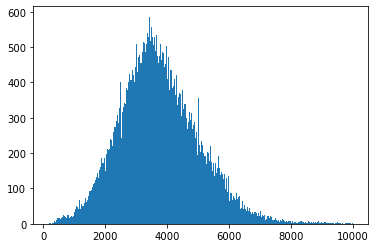

In [6]:
plt.hist(df.Prix_m2_total,bins=300);

# Adding specific datas

In fact, should be done in the produce_datasets script 

In [7]:
def add_speficic_datas(df) : 
    
    print("Adding info about public transportation...")
    
    with open('../Datas/Raw_data/lyon_datasets/tcl_sytral.json') as f:
        data = json_normalize(json.load(f)['features'])
    data['geometry.coordinates'] = data['geometry.coordinates'].astype(str).str.split('[',expand=True)[1].str.split(']',expand=True)[0]
    df_transports = data['geometry.coordinates'].str.split(',',expand=True).rename(columns = {0:'longitude',1:'latitude'})
    df_transports.longitude = df_transports.longitude.astype(float).apply(radians)
    df_transports.latitude = df_transports.latitude.astype(float).apply(radians)
    
    
    
    model = BallTree(df_transports[['latitude', 'longitude']].values, metric='haversine')
    dist, indices = model.query(df[['latitude', 'longitude']].values,10)
    dist *= 6371
    

    df['dist_min_tc'] = dist[:,0]
    df['dist_mean_5_tc'] = np.mean(dist[:,:5],axis=1)
    df['dist_mean_10_tc'] = np.mean(dist[:,:10],axis=1)
    
    df['dist_std_5_tc'] = np.std(dist[:,:5],axis=1)
    df['dist_std_10_tc'] = np.std(dist[:,:10],axis=1)
    
    

    print("Now, adding economical datas about employement and demography per arrondissement...")
    # Adding pauverty for each arrondissement
    
    df_arr = pd.read_excel('../Datas/Raw_data/FILOSOFI_datasets/pauvrete_2018.xlsx')
    df_arr = df_arr[df_arr['Code géographique'].isin(df.code_commune.astype(str))].reset_index(drop=True).drop(
                    columns = ['Libellé géographique']).rename(columns = {'Code géographique' : 'code_commune'})
    
    df.code_commune = df.code_commune.astype(str)
    df = df.merge(df_arr,on='code_commune',how='left')
    
    
    
    print("Done.")
    
    
    
    return df

In [8]:
df = add_speficic_datas(df)

Adding info about public transportation...
Now, adding economical datas about employement and demography per arrondissement...
Done.


In [9]:
df

id_mutation nature_mutation  valeur_fonciere  code_postal code_commune  \
0      2014-702394           Vente         170000.0      69004.0        69384   
1      2014-702395           Vente         220000.0      69004.0        69384   
2      2014-702396           Vente         164000.0      69005.0        69385   
3      2014-702397           Vente         126000.0      69009.0        69389   
4      2014-702398           Vente         155120.0      69004.0        69384   
...            ...             ...              ...          ...          ...   
45966  2020-229255           Vente         186400.0      69003.0        69383   
45967  2020-229257           Vente         295000.0      69003.0        69383   
45968  2020-229259           Vente         190000.0      69008.0        69388   
45969  2020-229260           Vente         377000.0      69008.0        69388   
45970  2020-229261           Vente         220000.0      69007.0        69387   

       code_departement  type_local  surface_reelle_bati  \
0                    69         0.0                 66.0   
1                    69         0.0                 60.0   
2                    69         0.0                 66.0   
3                    69         0.0                 60.0   
4                    69         0.0                 40.0   
...                 ...         ...                  ...   
45966                69         0.0                 35.0   
45967                69         0.0                 54.0   
45968                69         0.0                 51.0   
45969                69         0.0                 68.0   
45970                69         0.0                 46.0   

       nombre_pieces_principales  surface_terrain  longitude  latitude  \
0                              4              0.0   0.084066  0.799001   
1                              3              0.0   0.084168  0.798948   
2                              4              0.0   0.083557  0.798450   
3                              2              0.0   0.083802  0.798842   
4                              2              0.0   0.084396  0.798965   
...                          ...              ...        ...       ...   
45966                          2              0.0   0.084854  0.798478   
45967                          2              0.0   0.085060  0.798458   
45968                          2              0.0   0.084860  0.798298   
45969                          3              0.0   0.084951  0.798315   
45970                          2              0.0   0.084273  0.798280   

      type_local_str  year  quarter  month  Prix_m2_bati  Prix_m2_total  \
0        Appartement  2014        1      1   2575.757576    2575.757576   
1        Appartement  2014        1      1   3666.666667    3666.666667   
2        Appartement  2014        1      1   2484.848485    2484.848485   
3        Appartement  2014        1      1   2100.000000    2100.000000   
4        Appartement  2014        1      1   3878.000000    3878.000000   
...              ...   ...      ...    ...           ...            ...   
45966    Appartement  2020        2      6   5325.714286    5325.714286   
45967    Appartement  2020        2      6   5462.962963    5462.962963   
45968    Appartement  2020        2      6   3725.490196    3725.490196   
45969    Appartement  2020        2      6   5544.117647    5544.117647   
45970    Appartement  2020        2      6   4782.608696    4782.608696   

       arrondissement  dist_min_lycee type_plus_proche_lycee  \
0                  84        0.408662                   C301   
1                  84        0.371926                   C302   
2                  85        0.175884                   C302   
3                  89        0.193837                   C301   
4                  84        0.420113                   C302   
...               ...             ...                    ...   
45966              83        0.211701                   C301   
45967      

# Plot heat map of the price on the target city : 

In [10]:
# Takes a lot of memory, increase nb_plots for more details
# Static map after that

center = [45.764043,4.835659]
nb_plots = 5e3

hmap = folium.Map(location= center, zoom_start=12)

max_price = float(df['Prix_m2_bati'].max())
min_price = float(df['Prix_m2_bati'].min())
colormap = cm.LinearColormap(colors=['blue','red'], vmin=min_price,vmax=max_price)



lat = list(df.loc[:nb_plots].latitude_real)
lon = list(df.loc[:nb_plots].longitude_real)
price = list(df.loc[:nb_plots].Prix_m2_bati)


for loc, p in tqdm(zip(zip(lat, lon), price)):
    folium.Circle(
        location=loc,
        radius=10,
        fill=True,
        color=colormap(p),
    ).add_to(hmap)
    
hmap.add_child(colormap)

display(hmap)

5001it [00:00, 48488.45it/s]


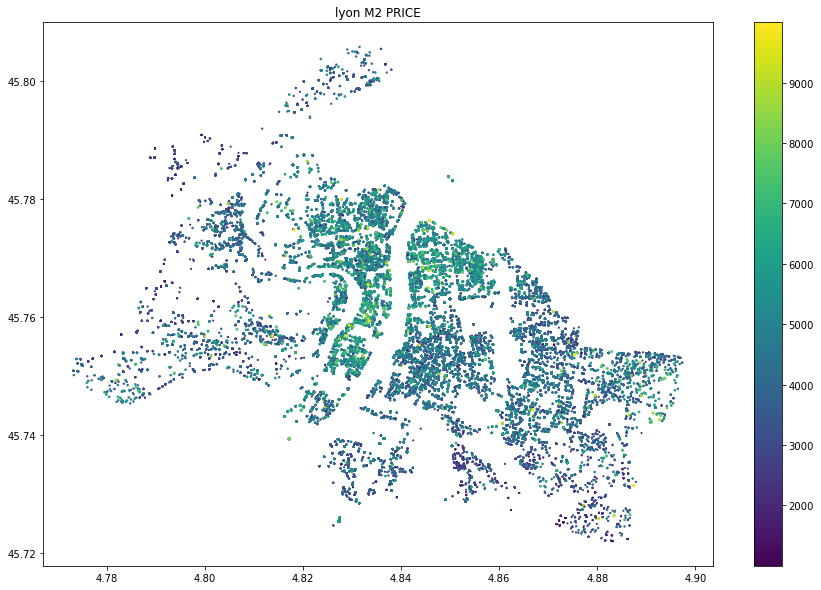

In [11]:
plt.figure(figsize = (15,10))
plt.scatter(df.longitude_real.values,df.latitude_real.values, c = df.Prix_m2_bati.values,s=5*df.Prix_m2_bati.values/df.Prix_m2_bati.values.max())
plt.colorbar()
plt.title('{} M2 PRICE'.format(DEPARTMENT))
plt.show()

In [12]:
from sklearn.metrics import mean_absolute_percentage_error
def evaluate_model(y_test,y_pred):
    error= np.abs((y_test-y_pred)/y_test)*100
    print('Mean absolute percentage error = {}'.format(mean_absolute_percentage_error(y_test,y_pred)*100))
    print('Median absolute percentage error = {}'.format(np.median(error)))

In [13]:
X_train, X_test, Y_train, Y_test = scsplit(df,df.Prix_m2_bati,test_size = 0.2,train_size = 0.8,stratify = df.valeur_fonciere,random_state=10)

In [14]:
index_train = X_train.index
index_test = X_test.index

prix_m2_train = Y_train.values
prix_m2_test = Y_test.values
vf_train = df.loc[index_train].valeur_fonciere
vf_test = df.loc[index_test].valeur_fonciere

In [15]:
categorical_features = ['nombre_pieces_principales','type_local','year','quarter',
 'month','arrondissement']

quantitative_features = [
 'surface_reelle_bati',
 'surface_terrain',
 'dist_min_lycee',
 'dist_min_5_lycee',
 'dist_min_maternelle',
 'dist_min_ecoles_elementaires',
 'dist_min_colleges',
 'dist_min_5_colleges',
 'dist_min_sup',
 'dist_min_5_sup',
 'dist_min_supermarche',
 'dist_min_boulangerie',
 'dist_min_boucherie',
 'dist_min_poste',
 'dist_min_pharmacie',
 'dist_min_aeroport',
 'dist_min_culture',
 'dist_min_generaliste',
 'dist_min_banque',
 'dist_min_urgence',
 'dist_min_specialiste',
 'dist_min_dent',
 'dist_min_infirimier',
 'dist_min_creche',
 'dist_min_gare',
 'voisinage',
 'voisinage_total',
 'mean_dist_5_NN',
 'mean_dist_10_NN',
 'mean_dist_20_NN',
 'mean_dist_25_NN',
 'mean_dist_50_NN',
 'std_dist_5_NN',
 'std_dist_10_NN',
 'std_dist_20_NN',
 'std_dist_25_NN',
 'std_dist_50_NN',
 'Médiane du niveau vie (€)',
 'Taux de pauvreté-30 à 39 ans  (%)',
 'dont part des prestations familiales (%)',
 'Rapport interdécile 9e décile/1er décile',
'dist_min_tc','dist_mean_5_tc','dist_mean_10_tc',
'dist_std_5_tc','dist_std_10_tc'
 ]


X_train = X_train[categorical_features + quantitative_features]
X_test = X_test[categorical_features + quantitative_features]

In [16]:
preprocessor = ColumnTransformer(
        [
            ("preprocessor_cat",OneHotEncoder(handle_unknown = 'ignore'),categorical_features),
            ("preprocessor_quant",StandardScaler(),quantitative_features)
            
        ], remainder = 'drop')

In [17]:
MODEL = Pipeline(
        [
            ("preprocessor",preprocessor),
            ("regressor",LGBMRegressor(learning_rate=0.2,n_estimators=1000))
        ])


In [18]:
MODEL.fit(X_train,Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('preprocessor_cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['nombre_pieces_principales',
                                                   'type_local', 'year',
                                                   'quarter', 'month',
                                                   'arrondissement']),
                                                 ('preprocessor_quant',
                                                  StandardScaler(),
                                                  ['surface_reelle_bati',
                                                   'surface_terrain',
                                                   'dist_min_lycee',
                                                   'dist_min_5_lycee',
                                                   'dist_min_maternelle',
              

In [19]:
predicted = MODEL.predict(X_test)
evaluate_model(Y_test,predicted)

Mean absolute percentage error = 16.581027160245714
Median absolute percentage error = 10.493060871492757


In [20]:
valeur_fonciere = vf_test
prediction_vf = predicted*X_test.surface_reelle_bati

In [21]:
evaluate_model(valeur_fonciere,prediction_vf)

Mean absolute percentage error = 16.581027160245718
Median absolute percentage error = 10.493060871492753


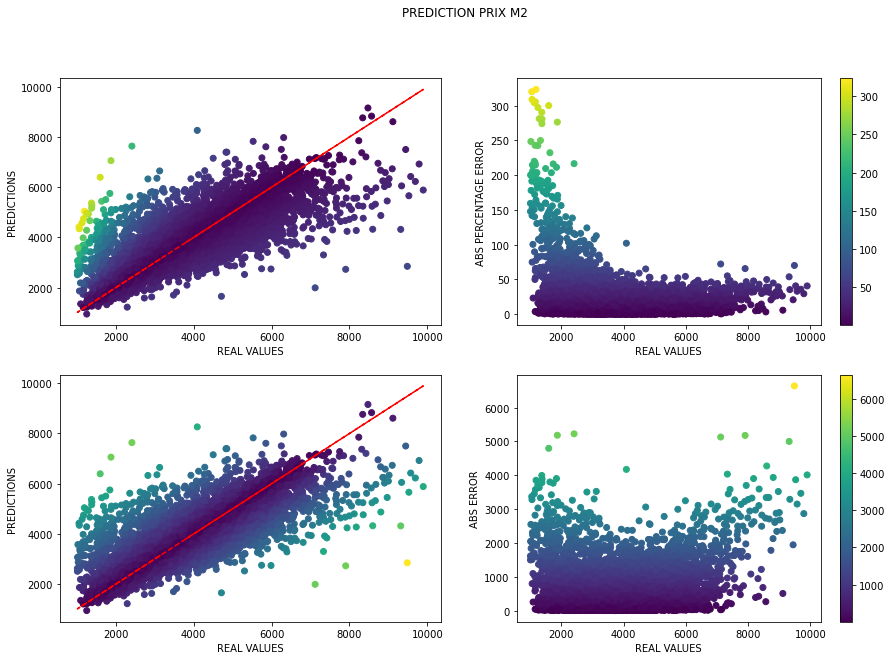

In [22]:
mape = np.abs((predicted - Y_test)/Y_test)*100

plt.figure(figsize = (15,10))
plt.subplot(2,2,1)
plt.scatter(Y_test,predicted,c= mape)
plt.plot(Y_test,Y_test,'r--')
plt.xlabel('REAL VALUES')
plt.ylabel('PREDICTIONS')
plt.subplot(2,2,2)
mape = np.abs((predicted - Y_test)/Y_test)*100
plt.scatter(Y_test,mape,c= mape)
plt.xlabel('REAL VALUES')
plt.ylabel('ABS PERCENTAGE ERROR')

plt.colorbar()


mae = np.abs(predicted - Y_test)

plt.subplot(2,2,3)
plt.scatter(Y_test,predicted,c= mae)
plt.plot(Y_test,Y_test,'r--')
plt.xlabel('REAL VALUES')
plt.ylabel('PREDICTIONS')
plt.subplot(2,2,4)
plt.scatter(Y_test,mae,c= mae)
plt.xlabel('REAL VALUES')
plt.ylabel('ABS ERROR')



plt.suptitle('PREDICTION PRIX M2')
plt.colorbar()

Mean absolute percentage error = 16.581027160245718
Median absolute percentage error = 10.493060871492753


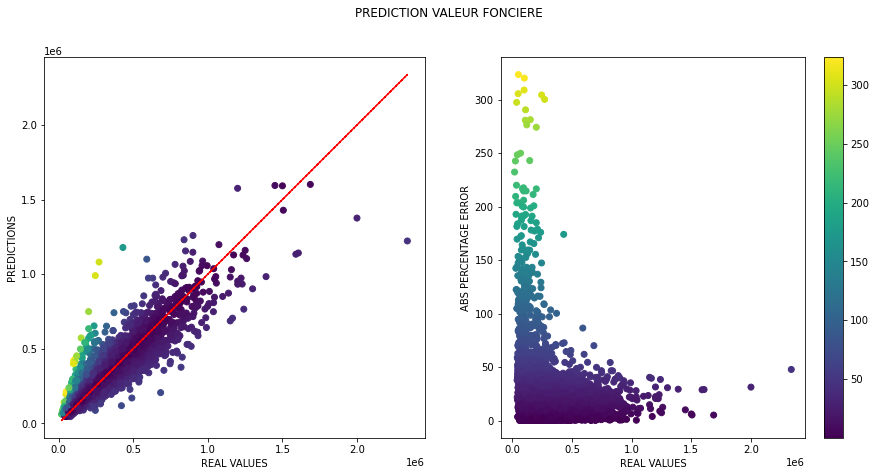

In [23]:
mape = np.abs((valeur_fonciere - prediction_vf)/valeur_fonciere)*100

evaluate_model(valeur_fonciere,prediction_vf)

plt.figure(figsize = (15,7))
plt.subplot(1,2,1)
plt.scatter(valeur_fonciere,prediction_vf,c= mape)
plt.plot(valeur_fonciere,valeur_fonciere,'r--')
plt.xlabel('REAL VALUES')
plt.ylabel('PREDICTIONS')
plt.subplot(1,2,2)

plt.scatter(valeur_fonciere,mape,c= mape)
plt.xlabel('REAL VALUES')
plt.ylabel('ABS PERCENTAGE ERROR')
plt.suptitle('PREDICTION VALEUR FONCIERE')
plt.colorbar()

# Spatial distribution of the error : 

In [24]:
error = mape

hmap = folium.Map(location= center, zoom_start=10)

df_test = df[df.index.isin(index_test)] 
nb_plots = 1e3

max_error = max(error)
min_error = min(error)
mean_error = np.mean(error)
med_error = np.median(error)
colormap = cm.LinearColormap(colors=['lightblue','red'], index = [min_error,max_error],
                             vmin=min_error,vmax=max_error)



lat = list(df_test.reset_index().loc[:nb_plots].latitude_real)
lon = list(df_test.reset_index().loc[:nb_plots].longitude_real)
price = list(error)


for loc, p in tqdm(zip(zip(lat, lon), error)):
    folium.Circle(
        location=loc,
        radius=p,
        fill=True,
        color=colormap(p),
        fill_opacity=p/max_error).add_to(hmap)
    
hmap.add_child(colormap)

display(hmap)

1001it [00:00, 5725.74it/s]


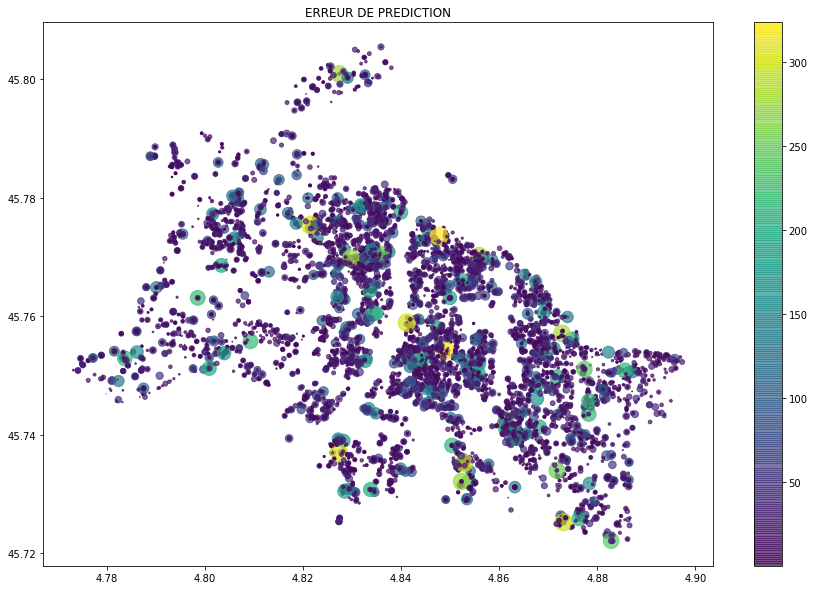

In [25]:
plt.figure(figsize = (15,10))
plt.scatter(df_test.longitude_real.values,df_test.latitude_real.values, c = error,s=error,alpha=0.7)
plt.colorbar()
plt.title('ERREUR DE PREDICTION')
plt.show()

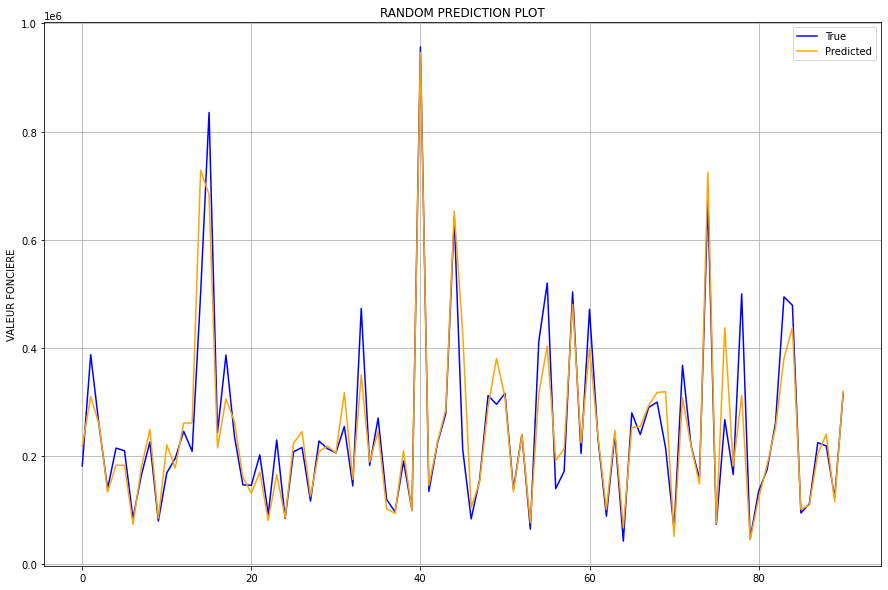

In [26]:
plt.figure(figsize=(15,10))
n = len(Y_test)
number = int(n/100)
array = np.arange(n)
shuffle(array)

i = randint(0,n-number)

prediction = prediction_vf
prediction_plot = []
true_plot = []

for indice in array[i:i+number]:
    true_plot.append(valeur_fonciere.values[indice])
    prediction_plot.append(prediction.values[indice])
    

plt.plot(range(number),true_plot,'b',label='True')
plt.plot(range(number),prediction_plot,'orange',label='Predicted')
plt.grid()
plt.title('RANDOM PREDICTION PLOT')
plt.ylabel('VALEUR FONCIERE')
plt.legend()

In [27]:
n_repeats = 5

feature_importances = permutation_importance(
    MODEL, X_test, Y_test, n_repeats=n_repeats
)

In [28]:
sorted_idx = feature_importances.importances_mean.argsort()[::-1]
names = X_test.columns.copy()

for i in range(len(names)):
    features = feature_importances.importances[sorted_idx].T[:,i]
    series = pd.Series(features)
    if i == 0 :
        dfa = pd.DataFrame(series,columns = ['Importance'])
        dfa['Features'] = np.array(names)[sorted_idx][i]
    else : 
        df2 = pd.DataFrame(series,columns = ['Importance'])
        df2['Features'] = np.array(names)[sorted_idx][i]
        dfa = pd.concat([dfa,df2])

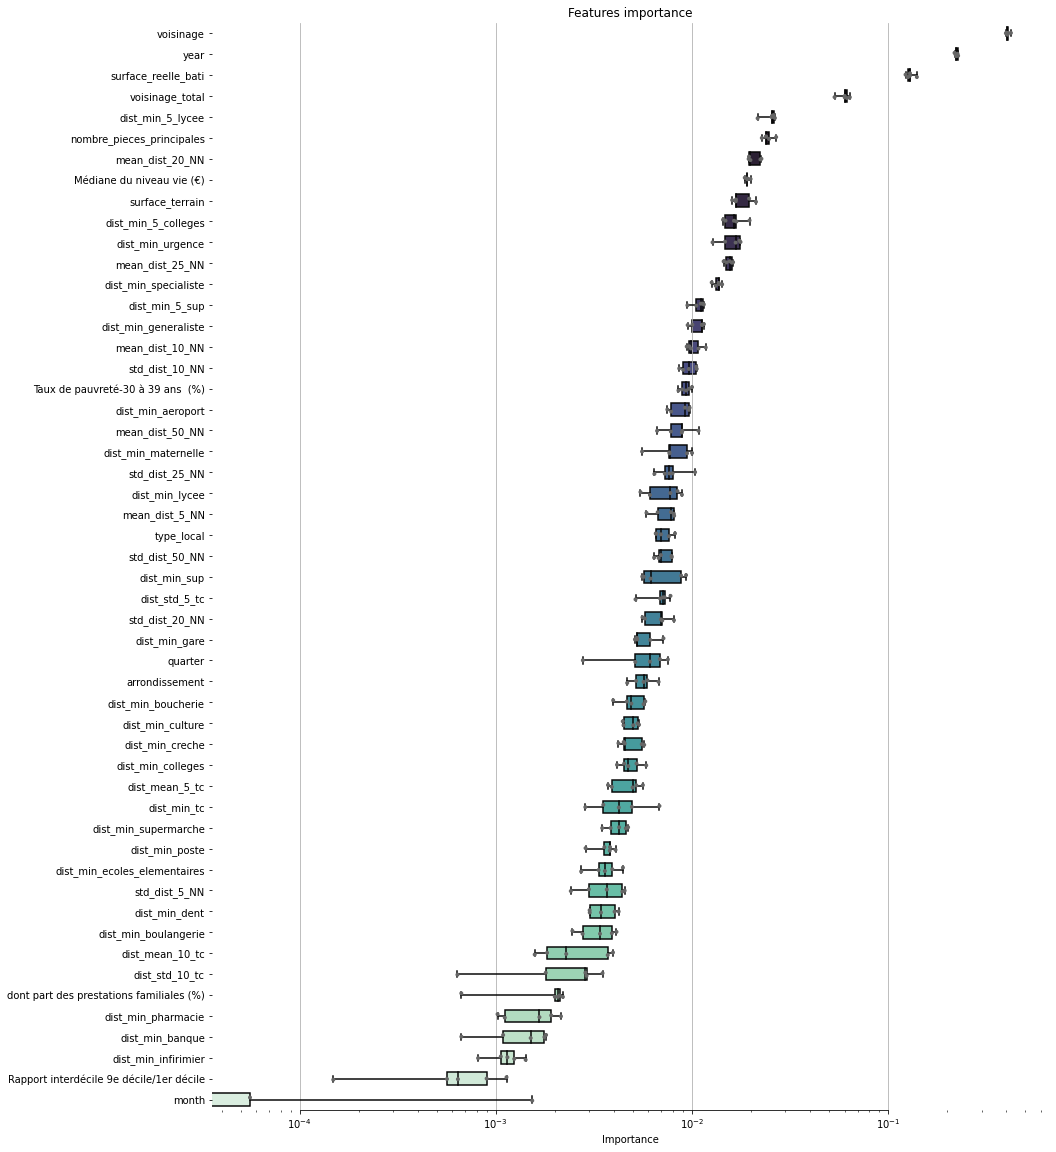

In [29]:
# Plot the orbital period with horizontal boxes

f, ax = plt.subplots(figsize=(15,20))
ax.set_xscale("log")
sns.boxplot(x='Importance', y='Features',data=dfa,
            whis=[0, 100], width=.6, palette="mako")


sns.stripplot(x='Importance', y='Features',data=dfa,
              size=4, color=".4", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
ax.set_title('Features importance');

# Neural Network

In [30]:
X_pre_train = X_train.copy()
X_pre_test = X_test.copy()
Y_train = prix_m2_train
Y_test = prix_m2_test

In [31]:
X_train_keras = preprocessor.transform(X_pre_train[categorical_features + quantitative_features])
X_test_keras = preprocessor.transform(X_pre_test[categorical_features + quantitative_features])

In [32]:
callback = EarlyStopping(patience=15,restore_best_weights = True)

In [33]:
# Decalaration of our neural network architechture. We use batchnormalization layers as well 
# as dropout to prevent overfitting
def create_network():
    model = Sequential()
    model.add(Dense(16, activation='relu',input_shape = (X_train_keras.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32, activation='selu'))
    model.add(Dense(16, activation='selu'))
    model.add(Dense(8, activation='selu'))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer = 'adam', loss = 'mean_absolute_error')

    return model

In [34]:
keras_regressor = KerasRegressor(build_fn=create_network, epochs=1500,verbose=1,batch_size = 128)

In [35]:
keras_regressor.fit(X_train_keras,Y_train,callbacks=[callback],validation_split=0.2)

Train on 29420 samples, validate on 7356 samples
Epoch 1/1500
29420/29420 [==============================] - 1s 22us/step - loss: 2147.4101 - val_loss: 767.4962
Epoch 2/1500
29420/29420 [==============================] - 0s 14us/step - loss: 719.7916 - val_loss: 680.6228
Epoch 3/1500
29420/29420 [==============================] - 0s 13us/step - loss: 671.8216 - val_loss: 659.3049
Epoch 4/1500
29420/29420 [==============================] - 0s 14us/step - loss: 654.8215 - val_loss: 647.0378
Epoch 5/1500
29420/29420 [==============================] - 0s 14us/step - loss: 645.1973 - val_loss: 640.1592
Epoch 6/1500
29420/29420 [==============================] - 0s 13us/step - loss: 641.5882 - val_loss: 635.0546
Epoch 7/1500
29420/29420 [==============================] - 0s 13us/step - loss: 636.9336 - val_loss: 630.2933
Epoch 8/1500
29420/29420 [==============================] - 0s 14us/step - loss: 635.8124 - val_loss: 628.3516
Epoch 9/1500
29420/29420 [==============================] - 0s

Epoch 74/1500
29420/29420 [==============================] - 0s 14us/step - loss: 596.0209 - val_loss: 609.9983
Epoch 75/1500
29420/29420 [==============================] - 0s 13us/step - loss: 595.5845 - val_loss: 609.2832
Epoch 76/1500
29420/29420 [==============================] - 0s 13us/step - loss: 596.9568 - val_loss: 610.3658
Epoch 77/1500
29420/29420 [==============================] - 0s 13us/step - loss: 596.6991 - val_loss: 610.8886


In [36]:
prediction = keras_regressor.predict(X_test_keras)
evaluate_model(prediction,Y_test)

9195/9195 [==============================] - 0s 6us/step
Mean absolute percentage error = 15.86614759560214
Median absolute percentage error = 11.635856057156683


In [37]:
prediction_vf = prediction*X_test.surface_reelle_bati
evaluate_model(prediction_vf,vf_test)

Mean absolute percentage error = 15.866147595602143
Median absolute percentage error = 11.635856057156689


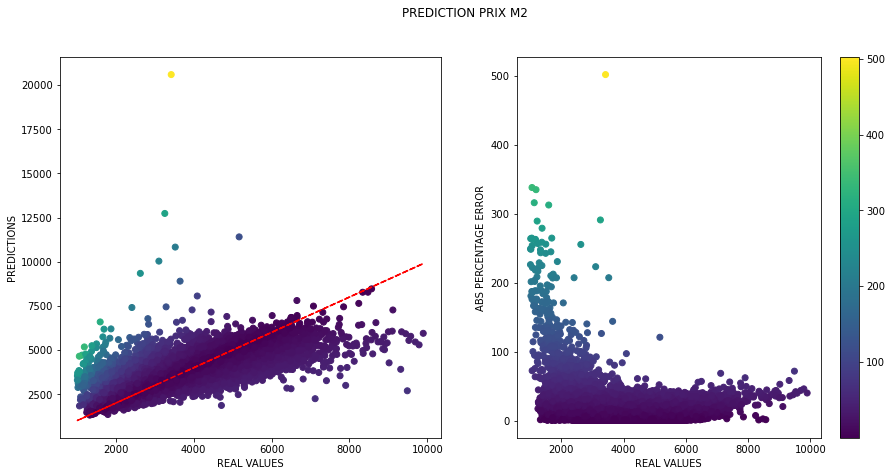

In [38]:
mape = np.abs((Y_test-prediction)/Y_test)*100

plt.figure(figsize = (15,7))
plt.subplot(1,2,1)
plt.scatter(Y_test,prediction,c= mape)
plt.plot(Y_test,Y_test,'r--')
plt.xlabel('REAL VALUES')
plt.ylabel('PREDICTIONS')
plt.subplot(1,2,2)
mape = np.abs((prediction - Y_test)/Y_test)*100
plt.scatter(Y_test,mape,c= mape)
plt.xlabel('REAL VALUES')
plt.ylabel('ABS PERCENTAGE ERROR')
plt.suptitle('PREDICTION PRIX M2')
plt.colorbar()

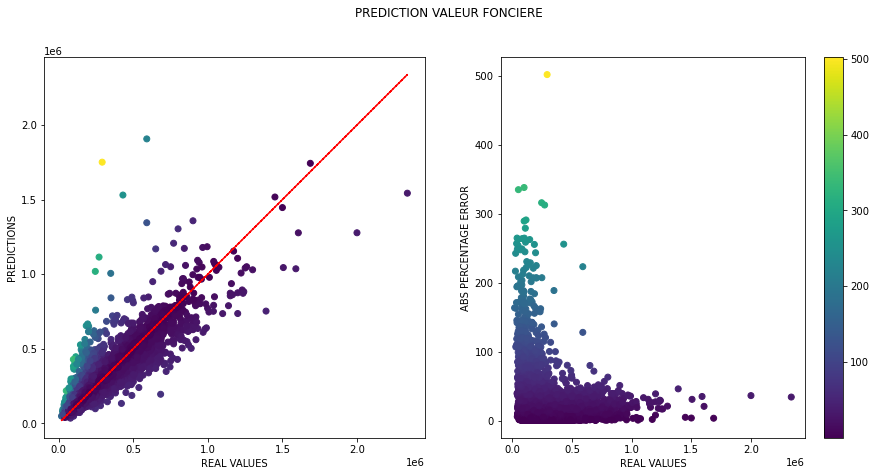

In [40]:
mape = np.abs((vf_test - prediction_vf)/vf_test)*100

plt.figure(figsize = (15,7))
plt.subplot(1,2,1)
plt.scatter(vf_test,prediction_vf,c= mape)
plt.plot(vf_test,vf_test,'r--')
plt.xlabel('REAL VALUES')
plt.ylabel('PREDICTIONS')
plt.subplot(1,2,2)

plt.scatter(vf_test,mape,c= mape)
plt.xlabel('REAL VALUES')
plt.ylabel('ABS PERCENTAGE ERROR')
plt.suptitle('PREDICTION VALEUR FONCIERE')
plt.colorbar();

# MIXED MODEL 

In [41]:
mixed = np.average([prediction,predicted],axis=0,weights=[0.5,0.5])
evaluate_model(mixed,Y_test)

Mean absolute percentage error = 14.493253092044842
Median absolute percentage error = 10.54861652481627


In [42]:
part_keras = np.linspace(0,1,101)
list_mape = []
min_loss = np.inf 
best_tradeoff = 0
best_mixed = mixed

for i in part_keras : 
    mixed = np.average([prediction,predicted],axis=0,weights=[i,1-i])
    mae = np.mean(np.abs(mixed-Y_test))
    list_mape.append(mae)
    if mae < min_loss : 
        best_tradeoff = i 
        min_loss = mae
        best_mixed = mixed
        

Text(0.5, 1.0, 'BEST PART KERAS : 0.25')

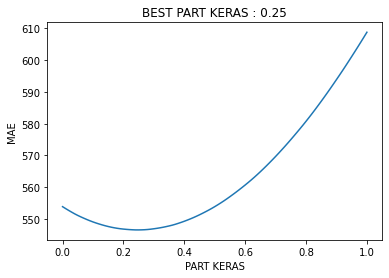

In [43]:
plt.figure()
plt.plot(part_keras,list_mape)
plt.ylabel('MAE')
plt.xlabel('PART KERAS')
plt.title('BEST PART KERAS : {}'.format(best_tradeoff))

In [44]:
evaluate_model(best_mixed,Y_test)

Mean absolute percentage error = 14.367918936994473
Median absolute percentage error = 10.277935994588777


In [45]:
Boundary = 20

ap_error = (np.abs(Y_test-best_mixed)/Y_test)*100
print("Prediction with less than {}% error represents {}% of predictions.".format(Boundary,(1 - (len(Y_test) - sum(ap_error < Boundary))/len(Y_test))*100))

Prediction with less than 20% error represents 76.10657966286026% of predictions.


# Make the true training of the two models, save optimal tradeoff

In [46]:
X = df[categorical_features + quantitative_features]
Y = df.Prix_m2_bati

In [47]:
preprocessor = ColumnTransformer(
        [
            ("preprocessor_cat",OneHotEncoder(handle_unknown = 'ignore'),categorical_features),
            ("preprocessor_quant",StandardScaler(),quantitative_features)
            
        ], remainder = 'drop')

In [48]:
MODEL = Pipeline(
        [
            ("preprocessor",preprocessor),
            ("regressor",LGBMRegressor(learning_rate=0.2,n_estimators=1000))
        ])

In [49]:
MODEL.fit(X,Y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('preprocessor_cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['nombre_pieces_principales',
                                                   'type_local', 'year',
                                                   'quarter', 'month',
                                                   'arrondissement']),
                                                 ('preprocessor_quant',
                                                  StandardScaler(),
                                                  ['surface_reelle_bati',
                                                   'surface_terrain',
                                                   'dist_min_lycee',
                                                   'dist_min_5_lycee',
                                                   'dist_min_maternelle',
              

In [50]:
X_keras = preprocessor.transform(X)

In [51]:
callback = EarlyStopping(patience=15,restore_best_weights = True)

In [52]:
# Decalaration of our neural network architechture. We use batchnormalization layers as well 
# as dropout to prevent overfitting
def create_network():
    model = Sequential()
    model.add(Dense(16, activation='relu',input_shape = (X_keras.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32, activation='selu'))
    model.add(Dense(16, activation='selu'))
    model.add(Dense(8, activation='selu'))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer = 'adam', loss = 'mean_absolute_error')

    return model

In [53]:
keras_regressor = KerasRegressor(build_fn=create_network, epochs=1500,verbose=1,batch_size = 128)

In [54]:
keras_regressor.fit(X_keras,Y,callbacks=[callback],validation_split=0.2)

Train on 36776 samples, validate on 9195 samples
Epoch 1/1500
36776/36776 [==============================] - 1s 19us/step - loss: 2217.1163 - val_loss: 1242.0227
Epoch 2/1500
36776/36776 [==============================] - 1s 14us/step - loss: 672.0850 - val_loss: 1180.3201
Epoch 3/1500
36776/36776 [==============================] - 0s 13us/step - loss: 632.9971 - val_loss: 1194.7833
Epoch 4/1500
36776/36776 [==============================] - 0s 13us/step - loss: 620.2754 - val_loss: 1188.7125
Epoch 5/1500
36776/36776 [==============================] - 0s 14us/step - loss: 614.5207 - val_loss: 1169.2593
Epoch 6/1500
36776/36776 [==============================] - 0s 13us/step - loss: 610.3728 - val_loss: 1176.3978
Epoch 7/1500
36776/36776 [==============================] - 1s 14us/step - loss: 607.5528 - val_loss: 1175.2592
Epoch 8/1500
36776/36776 [==============================] - 1s 14us/step - loss: 604.1731 - val_loss: 1129.8016
Epoch 9/1500
36776/36776 [============================

# Saving models

In [55]:
filename = './models/Pipeline_LGBM_{}.sav'.format(DEPARTMENT)
pickle.dump(MODEL, open(filename, 'wb'))

In [56]:
filename = './models/preprocessor_keras_{}.sav'.format(DEPARTMENT)
pickle.dump(preprocessor, open(filename, 'wb'))

In [57]:
filename = './models/keras_{}.h5'.format(DEPARTMENT)
keras_regressor.model.save(filename)